# 第一部分：决策树的构造
## 1.1 计算给定数据集的经验熵

## 本案例主要是讲了ID3算法。

In [1]:
# 导入所需的模块
from math import log
import operator

In [2]:
def calcShannonEnt(dataSet):
    """
    此函数是计算经验熵(empricial entropy)
    dataSet: 传入的是列表格式，不能传入Dataframe格式
    
    return: shannonEntropy为最终求得的经验熵
    """
    numEntries = len(dataSet)
    # 1、为所有可能的分类创建字典
    labelCounts = {}    # labelCounts以字典的格式存储每一类别出现的次数
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    
    # 2、计算熵值(entropy)
    shannonEntropy = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEntropy -= prob*log(prob, 2)    # 以2为底求对数
    return shannonEntropy

In [3]:
# 测试calcShannonEnt()
def createDataset():
    dataSet = [[1,1,'yes'],
               [1,1,'yes'],
              [1,0,'no'],
              [0,1,'no'],
              [0,1,'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels
myDat, labels = createDataset()
print(myDat)
calcShannonEnt(myDat)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


0.9709505944546686

In [4]:
-0.4*log(0.4,2)-0.6*log(0.6,2)

0.9709505944546686

即最终求得的经验熵为：0.97095；  
熵越高则说明混合的数据越多，如myDat添加一行数据[1,1,'maybe'], 会发现熵变大了。

In [5]:
myDat.append([1,1,'maybe'])
print(myDat)
calcShannonEnt(myDat)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no'], [1, 1, 'maybe']]


1.4591479170272448

## 1.2 计算信息增益(information gain)

计算步骤：
1. 先计算经验熵$H(D)$；
2. (在计算经验条件熵之前先划分数据集)再计算经验条件熵$H(D|A)$；
3. 最后利用经验熵和经验条件熵计算A特征的信息增益$g(D, A) = H(D) - H(D|A)$

### 1.2.1 划分数据集 

In [6]:
def splitDataSet(dataSet, axis, value):
    """
    dataSet: 数据集, 传入的是列表格式【numpy格式的数据还需额外用tolist转成list】
    axis：特征A所在的列号（从0开始计数）
    value：根据特征A中的值value进行划分
    
    return:
    retDataSet: 划分后的不包含特征A的列的结果，为list格式（也可以转为numpy格式）
    """
    # 1、创建新的list对象
    retDataSet = []

    # 2、根据特征A的value值划分数据集
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [7]:
# test splitDataSet
myDat, labels = createDataset()
print(myDat)
splitDataSet(myDat, 0, 0)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]


[[1, 'no'], [1, 'no']]

### 1.2.2 计算information gain并选出最优的特征（ID3算法）

In [8]:
def chooseBestFeatureToSplit(dataSet):
    """
    dataSet: 为列表格式【array格式还需用tolist转为list】
    
    return: 最大信息增益对应特征的下标和信息增益值
    """
    numFeatures = len(dataSet[0])-1    # -1是为了去掉目标值所在列
    empericalEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]    # feature[i]只从每个example提取特征值A做在列的元素
        # 创建唯一的分类标签列表
        uniquevals = set(featList)
        conditionalEntropy = 0.0
        # 计算每种划分方式的信息熵
        for values in uniquevals:
            subDataSet = splitDataSet(dataSet,i,values)
            prob = len(subDataSet)/float(len(dataSet))
            conditionalEntropy += prob*calcShannonEnt(subDataSet)
        infoGain = empericalEntropy - conditionalEntropy
        if infoGain>bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    return bestInfoGain, bestFeature

In [9]:
# test chooseBestFeatureToSplit()
myDat, labels = createDataset()
bestInfoGain, bestFeature = chooseBestFeatureToSplit(myDat)
print(myDat)
print(bestInfoGain)
print(bestFeature)

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
0.4199730940219749
0


## 1.3 递归构建决策树
在1.2中已经可以计算出信息增益，接下来要做的就是以**递归**的方式构建决策树，在构建决策树之前，还有一步那就是处理可能出现的特殊情况：  
1. 样本中只出现了一种类别，返回树T；
2. 样本中出现了多种类别，但是数据集中只有目标值这一列，通过多数表决的方式判定其属于哪一类；

处理完以上两种特殊情况后，就可以用递归构建一颗完整的决策树了。

In [10]:
def majorityCnt(classList):
    """
    构造一个多数表决分类器
    classList：为目标值组成的列表，如['yes','no','no','yes','yes'……]
    
    return: 返回出现次数最多的类别名称
    """
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount += 1
    sortedClassCount = sorted(classCount.iterms(), key=operator.itemgetter(1), reverse=True)
    ### operator.itemgetter(1)是以其第二个元素进行排序 ###
    ### reverse=True是从大到小进行排序 ###
    return sortedClassCount[0][0]

In [11]:
# 创建决策树
def createTree(dataSet, labels):
    """
    dataSet: 
    labels: 所包含的所有特征的名称，如['年龄','有工作','有自己的房子','信贷情况']
    """
    # 先提取构造classList, 即提取数据集的最后一列
    classList = [example[-1] for example in dataSet]
    
    # 1、处理第一种特殊情况：所有的目标值只有一类
    if classList.count(classList[0])==len(classList):
        return classList[0]
    
    # 2、处理第二种特殊情况：数据集中只有目标值这一列，而且有多个类别
    if len(dataSet[0])==1:
        return majorityCnt(classList)
    
    # 3、处理正常情况
    bestInfoGain, bestFeature = chooseBestFeatureToSplit(dataSet)
    print(bestInfoGain)
    bestFeatLabel = labels[bestFeature]
    myTree = {bestFeatLabel: {}}
    del(labels[bestFeature])    # 从原特征列表中删除选出的最优特征，下一步从剩下的特征中继续选择特征构建决策树
    featValues = [example[bestFeature] for example in dataSet]
    uniqueVals = set(featValues)
    
    # 进入递归，构建决策树
    for value in uniqueVals:
        sublabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeature, value), sublabels)
    return myTree

In [12]:
# test createTree(dataSet, labels)
myDat, labels = createDataset()
createTree(myDat, labels)

0.4199730940219749
0.9182958340544896


{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### 1.4 补充：构造一个函数可以把全是文字性描述的表转换为标称型的，以便对其计算信息熵并且构建决策树

In [13]:
import pandas as pd
import numpy as np

In [14]:
data = pd.read_table('loan_application_sample1.txt')
data2 = np.array(data.iloc[:, 1:])
data3 = data2.tolist()
print(data3)

[['青年', '否', '否', '一般', '否'], ['青年', '否', '否', '好', '否'], ['青年', '是', '否', '好', '是'], ['青年', '是', '是', '一般', '是'], ['青年', '否', '否', '一般', '否'], ['中年', '否', '否', '一般', '否'], ['中年', '否', '否', '好', '否'], ['中年', '是', '是', '好', '是'], ['中年', '否', '是', '非常好', '是'], ['中年', '否', '是', '非常好', '是'], ['老年', '否', '是', '非常好', '是'], ['老年', '否', '是', '好', '是'], ['老年', '是', '否', '好', '是'], ['老年', '是', '否', '非常好', '是'], ['老年', '否', '否', '一般', '否']]


In [15]:
labels3 = np.array(data.columns).tolist()[1:-1]
print(labels3)
print(type(labels3))

['年龄', '有工作', '有自己的房子', '信贷情况']
<class 'list'>


In [16]:
createTree(dataSet=data3, labels=labels3)

0.4199730940219749
0.9182958340544896


{'有自己的房子': {'是': '是', '否': {'有工作': {'是': '是', '否': '否'}}}}

In [17]:
## 测试把列名转换为列表
labels1 = data.columns
print(labels1)
print(type(labels1))
print(np.array(labels1))
print(type(np.array(labels1)))
print(np.array(labels1).tolist())
print(type(np.array(labels1).tolist()))

Index(['ID', '年龄', '有工作', '有自己的房子', '信贷情况', '类别'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
['ID' '年龄' '有工作' '有自己的房子' '信贷情况' '类别']
<class 'numpy.ndarray'>
['ID', '年龄', '有工作', '有自己的房子', '信贷情况', '类别']
<class 'list'>


### 1.5 西瓜书上识别西瓜的例子

In [18]:
data = pd.read_table('watermalenData1.txt')
data2 = np.array(data.iloc[:, 1:])
data3 = data2.tolist()
print(data3)


[['青绿', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', '是'], ['乌黑', '蜷缩', '沉闷', '清晰', '凹陷', '硬滑', '是'], ['乌黑', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', '是'], ['青绿', '蜷缩', '沉闷', '清晰', '凹陷', '硬滑', '是'], ['浅白', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', '是'], ['青绿', '稍蜷', '浊响', '清晰', '稍凹', '软粘', '是'], ['乌黑', '稍蜷', '浊响', '稍糊', '稍凹', '软粘', '是'], ['乌黑', '稍蜷', '浊响', '清晰', '稍凹', '硬滑', '是'], ['乌黑', '稍蜷', '沉闷', '稍糊', '稍凹', '硬滑', '否'], ['青绿', '硬挺', '清脆', '清晰', '平坦', '软粘', '否'], ['浅白', '硬挺', '清脆', '稍糊', '平坦', '硬滑', '否'], ['浅白', '蜷缩', '浊响', '模糊', '平坦', '软粘', '否'], ['青绿', '稍蜷', '浊响', '稍糊', '凹陷', '硬滑', '否'], ['浅白', '稍蜷', '沉闷', '稍糊', '凹陷', '硬滑', '否'], ['乌黑', '稍蜷', '浊响', '清晰', '稍凹', '软粘', '否'], ['浅白', '蜷缩', '浊响', '模糊', '平坦', '硬滑', '否'], ['青绿', '蜷缩', '沉闷', '稍糊', '稍凹', '硬滑', '否']]


In [19]:
labels3 = np.array(data.columns).tolist()[1:-1]
print(labels3)
print(type(labels3))

['色泽', '根蒂', '敲声', '纹理', '脐肚', '触感']
<class 'list'>


In [20]:
createTree(dataSet=data3, labels=labels3)

0.3635040117533678
0.45810589515712374
0.2516291673878229
1.0
0.6500224216483541


{'纹理': {'清晰': {'根蒂': {'稍蜷': {'色泽': {'乌黑': {'触感': {'硬滑': '是', '软粘': '否'}},
      '青绿': '是'}},
    '硬挺': '否',
    '蜷缩': '是'}},
  '稍糊': {'触感': {'硬滑': '否', '软粘': '是'}},
  '模糊': '否'}}

## 1.2 使用matplotlib绘制树形图

In [21]:
import treePlotter

In [22]:
# treePlotter.createPlot()
treePlotter.retrieveTree(1)

{'no surfacing': {0: 'no',
  1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}

In [23]:
mytree = treePlotter.retrieveTree(0)

In [24]:
print(treePlotter.getNumLeafs(mytree))
print(treePlotter.getTreeDepth(mytree))

3
2


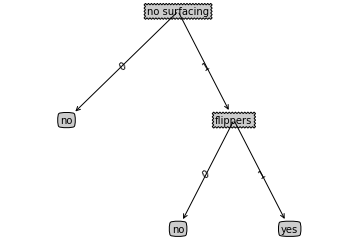

In [25]:
treePlotter.createPlot(mytree)

In [35]:
mytree['no surfacing'][3] = 'maybe'
mytree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}

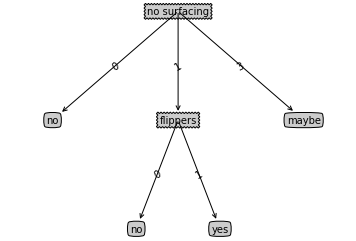

In [36]:
treePlotter.createPlot(mytree)

## 1.3 测试和存储分类器

### 1.3.1 测试算法：使用决策树进行分类

In [41]:
# 使用了递归来进行判断
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [42]:
myDat, labels = createDataset()
labels

['no surfacing', 'flippers']

In [43]:
myTree = treePlotter.retrieveTree(0)
mytree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}

In [44]:
classify(myTree, labels, [1, 0])

'no'

In [45]:
classify(myTree, labels, [1,1])

'yes'

### 1.3.2 使用pickle存储决策树
使用Python的pickle序列化对象，任何序列化的对象都能存储在磁盘上，然后在需要的时候将其读出来；任何对象都可以序列化。

In [60]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [61]:
storeTree(myTree, 'classifierStorage.txt')
grabTree('classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 1.4.1 使用决策树预测隐形眼镜类型

In [62]:
raw_data = pd.read_table('lenses.txt', header=None)

0.5487949406953986
0.7704260414863776
0.4591479170272448
0.9182958340544896
0.3166890883150208
1.0


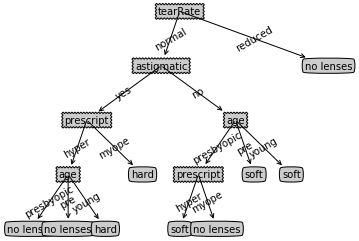

In [67]:
lenses = np.array(raw_data).tolist()
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
treePlotter.createPlot(lensesTree)

####  以下为写代码时的测试代码：

In [26]:
import numpy as np
import pandas as pd

In [27]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [28]:
# 测试Dataframe格式用for输出的结果：发现并不是输出每行的值
b = pd.DataFrame(a)
b

,0,1,2
0,1,2,3
1,4,5,6
2,7,8,9


In [29]:
# 测试dataframe能不能直接转为list：不行，dataframe需先转换为array再转为list
np.array(b).tolist()

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

In [30]:
for raws in b:
    print(raws)

0
1
2


In [31]:
for raws in a:
    print(raws)

[1 2 3]
[4 5 6]
[7 8 9]


In [32]:
# 测试把Dataframe转换为array格式
c = np.array(b)
c

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [33]:
# 测试for key in dictionary dictionary[key]输出的是什么：输出的是键所对应的值
d = {'a':1,'b':2,'c':3,'d':5}
for key in d:
    print(d[key])

1
2
3
5


In [34]:
#  测试列表转为numpy数组
e = [1,2,'a','b','c']
f = np.array(e)
g = pd.DataFrame(f)
g

,0
0,1
1,2
2,a
3,b
4,c
